In [12]:
import pandas as pd
import pdb
import numpy as np
import itertools
from snakemake.io import expand
import yaml
import os
import sys
import pathlib
import pyranges as pr
import cerberus 
import swan_vis as swan
import met_brewer
import seaborn as sns

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from utils import *
from sm_utils import *
from humanized_utils import *

In [2]:
config_file = 'config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
swan_file = expand(config['swan']['swan_graph'], 
                   analysis='hABKI_Swe_IB_HET_WT')[0]


In [6]:
sg = swan.read(swan_file)
obs = sg.adata.obs.copy(deep=True)

Read in graph from data/swan/hABKI_Swe_IB_HET_WT/swan_graph.p


In [7]:
# get unique genotypes, timepoints, tissues, etc
genotypes = obs.genotype.unique()
sex = obs.sex.unique()
ages = obs.age.unique()
tissues = obs.tissue.unique()

In [8]:
print(genotypes)
print(sex)
print(ages)
print(tissues)

['hABKI_Swe_IB_HET' 'hABKI_Swe_IB_WT']
['F' 'M']
['8_weeks']
['HC']


{0: '#2b9b81', 1: '#fe9b00', 2: '#f4c40f', 3: '#fbe183', 4: '#633372', 5: '#9b3441', 6: '#e6a2a6', 7: '#92c051', 8: '#1f6e9c', 9: '#9f5691', 10: '#e87b89'}


<AxesSubplot:xlabel='num'>

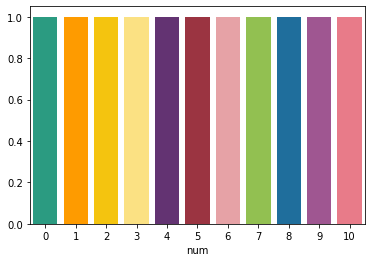

In [13]:
df = pd.DataFrame()
df['color'] = met_brewer.met_brew("Signac", n=11, brew_type="discrete")
df['num'] = df.index.tolist()
cmap = dict([(num, color) for num, color in zip(df.num.tolist(), df.color.tolist())])
print(cmap)
sns.barplot(df, y=[1 for i in range(len(df.index))], x='num', palette=cmap, saturation=1)

In [14]:
g_cmap = {'hABKI_Swe_IB_HET': cmap[1],
          'hABKI_Swe_IB_WT': cmap[2]}
s_cmap = {'M': cmap[3],
          'F': cmap[7]}
t_cmap = {'HC': cmap[10]}          

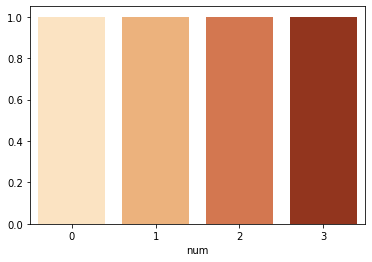

In [15]:
df = pd.DataFrame()
df['color'] = met_brewer.met_brew("OKeeffe2", n=4, brew_type="continuous")
df['num'] = df.index.tolist()
cmap = dict([(num, color) for num, color in zip(df.num.tolist(), df.color.tolist())])
sns.barplot(df, y=[1 for i in range(len(df.index))], x='num', palette=cmap, saturation=1)
order = ['8_weeks', 
         '10_weeks',
         '4_months',
         '18_months']
a_cmap = dict()
for i,t in enumerate(order):
    a_cmap[t] = cmap[i]

In [16]:
sg.set_metadata_colors('genotype', g_cmap)
sg.set_metadata_colors('tissue', t_cmap)
sg.set_metadata_colors('sex', s_cmap)
sg.set_metadata_colors('age', a_cmap)

In [45]:
import glob
# loc = 'data/swan/hABKI_Swe_IB_HET_WT/*genotype_sex_du_*.tsv'
loc = 'data/swan/hABKI_Swe_IB_HET_WT/*genotype_du*.tsv'
du_df = pd.DataFrame()
for f in glob.glob(loc):
    print(f)
    feat = f.rsplit('_')[-1].split('.')[0]
    cond1 = f.rsplit('/')[-1].split('_vs_')[0]
    cond2 = f.rsplit('/')[-1].split('_vs_')[1].split('_genotype')[0]
    # print(feat)
    # print(cond1)
    # print(cond2)
    temp = pd.read_csv(f, sep='\t')
    temp['feat'] = feat
    temp['cond1'] = cond1
    temp['cond2'] = cond2
    du_df = pd.concat([du_df, temp], axis=0)

data/swan/hABKI_Swe_IB_HET_WT/hABKI_Swe_IB_HET_vs_hABKI_Swe_IB_WT_genotype_du_tss.tsv
data/swan/hABKI_Swe_IB_HET_WT/hABKI_Swe_IB_HET_vs_hABKI_Swe_IB_WT_genotype_du_ic.tsv
data/swan/hABKI_Swe_IB_HET_WT/hABKI_Swe_IB_HET_vs_hABKI_Swe_IB_WT_genotype_du_iso.tsv
data/swan/hABKI_Swe_IB_HET_WT/hABKI_Swe_IB_HET_vs_hABKI_Swe_IB_WT_genotype_du_tes.tsv


In [46]:
# filter on pval and dpi
adj_p_thresh = 0.05
dpi_thresh = 20
du_df = du_df.loc[(du_df.adj_p_val<=adj_p_thresh)&(du_df.dpi>=dpi_thresh)]
du_df.head()

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,neg_iso_1_dpi,neg_iso_2_dpi,adj_p_val,gname,feat,cond1,cond2
2,2,ENSMUSG00000000093,1.388435e-06,40.845074,ENSMUSG00000000093_1,NaN,40.845074,NaN,ENSMUSG00000000093_2,NaN,-40.845070,NaN,4.367816e-06,Tbx2,tss,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
3,3,ENSMUSG00000000125,5.169985e-04,48.148148,ENSMUSG00000000125_2,NaN,48.148148,NaN,ENSMUSG00000000125_3,NaN,-48.148148,NaN,1.106542e-03,Wnt3,tss,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
6,6,ENSMUSG00000000142,1.806651e-09,24.166666,ENSMUSG00000000142_3,NaN,24.166666,NaN,ENSMUSG00000000142_1,NaN,-24.166664,NaN,7.653674e-09,Axin2,tss,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
9,9,ENSMUSG00000000215,1.636984e-04,43.478264,ENSMUSG00000000215_3,NaN,43.478260,NaN,ENSMUSG00000000215_2,NaN,-43.478264,NaN,3.840663e-04,Ins2,tss,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
13,13,ENSMUSG00000000266,1.591154e-09,21.857925,ENSMUSG00000000266_3,NaN,21.857925,NaN,ENSMUSG00000000266_2,ENSMUSG00000000266_5,-15.846994,-6.010929,6.778117e-09,Mid2,tss,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT


In [47]:
du_df[['gid', 'feat']].groupby('feat').count()

,gid
feat,
ic,1404
iso,2642
tes,1843
tss,833


In [52]:
du_df = du_df.sort_values(by='dpi', ascending=False)
du_df.loc[(du_df.feat=='ic')&\
          (du_df.pos_iso_1_dpi.abs()!=100)&\
          (du_df.pos_iso_2_dpi.abs()!=100)&\
          (du_df.neg_iso_1_dpi.abs()!=100)&\
          (du_df.neg_iso_2_dpi.abs()!=100)].head()

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,neg_iso_1_dpi,neg_iso_2_dpi,adj_p_val,gname,feat,cond1,cond2
5259,5259,ENSMUSG00000032702,1.516959e-17,100.000000,ENSMUSG00000032702_14,ENSMUSG00000032702_11,41.176472,33.333336,ENSMUSG00000032702_7,ENSMUSG00000032702_8,-50.000000,-50.000000,1.050102e-16,Kank1,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
2198,2198,ENSMUSG00000022475,3.623319e-16,100.000000,ENSMUSG00000022475_15,ENSMUSG00000022475_16,50.000000,50.000000,ENSMUSG00000022475_14,ENSMUSG00000022475_1,-58.064514,-41.935482,2.295484e-15,Hdac7,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
7185,7185,ENSMUSG00000043336,0.000000e+00,99.840363,ENSMUSG00000043336_4,NaN,99.840363,NaN,ENSMUSG00000043336_3,NaN,-99.840363,NaN,0.000000e+00,Filip1l,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
2502,2502,ENSMUSG00000024030,3.390543e-156,97.386364,ENSMUSG00000024030_1,NaN,97.386364,NaN,ENSMUSG00000024030_6,ENSMUSG00000024030_7,-96.647728,-0.738636,3.670930e-154,Abcg1,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
6394,6394,ENSMUSG00000038738,0.000000e+00,96.565821,ENSMUSG00000038738_7,ENSMUSG00000038738_12,96.371529,0.194292,ENSMUSG00000038738_15,ENSMUSG00000038738_16,-68.464495,-15.625000,0.000000e+00,Shank1,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT


In [62]:
du_df.loc[(du_df.feat=='ic')].tail(20).head(10)

,Unnamed: 0,gid,p_val,dpi,pos_iso_1,pos_iso_2,pos_iso_1_dpi,pos_iso_2_dpi,neg_iso_1,neg_iso_2,neg_iso_1_dpi,neg_iso_2_dpi,adj_p_val,gname,feat,cond1,cond2
8711,8711,ENSMUSG00000064065,4.878671e-03,20.241936,ENSMUSG00000064065_10,NaN,20.241932,NaN,ENSMUSG00000064065_1,NaN,-20.241936,NaN,6.963542e-03,Ipcef1,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
3114,3114,ENSMUSG00000025964,2.397471e-17,20.199272,ENSMUSG00000025964_6,ENSMUSG00000025964_13,16.341699,2.037846,ENSMUSG00000025964_1,ENSMUSG00000025964_4,-18.720440,-1.478832,1.634963e-16,Adam23,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
3732,3732,ENSMUSG00000027895,1.504421e-73,20.177387,ENSMUSG00000027895_5,ENSMUSG00000027895_4,9.083715,8.560311,ENSMUSG00000027895_1,ENSMUSG00000027895_3,-13.805374,-6.372013,5.233430e-72,Kcnc4,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
5533,5533,ENSMUSG00000034248,1.761803e-04,20.175867,ENSMUSG00000034248_3,ENSMUSG00000034248_1,15.652174,4.523693,ENSMUSG00000034248_2,NaN,-20.175865,NaN,3.169667e-04,Slc25a37,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
7742,7742,ENSMUSG00000050373,3.106290e-19,20.175473,ENSMUSG00000050373_14,ENSMUSG00000050373_12,15.750000,4.369919,ENSMUSG00000050373_9,ENSMUSG00000050373_15,-15.297424,-4.878048,2.383138e-18,Snx21,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
7913,7913,ENSMUSG00000052566,4.229493e-09,20.175442,ENSMUSG00000052566_12,ENSMUSG00000052566_1,14.473684,5.701754,ENSMUSG00000052566_7,ENSMUSG00000052566_8,-12.280704,-7.894737,1.381071e-08,Hook2,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
494,494,ENSMUSG00000005102,1.547969e-06,20.168068,ENSMUSG00000005102_9,NaN,20.168068,NaN,ENSMUSG00000005102_1,NaN,-20.168068,NaN,3.704055e-06,Eif2ak4,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
8239,8239,ENSMUSG00000056999,5.924317e-33,20.156760,ENSMUSG00000056999_12,ENSMUSG00000056999_13,11.525648,7.964814,ENSMUSG00000056999_1,ENSMUSG00000056999_10,-18.148727,-2.008032,7.961886e-32,Ide,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
2383,2383,ENSMUSG00000022995,3.251038e-35,20.129075,ENSMUSG00000022995_9,ENSMUSG00000022995_20,13.016104,7.112971,ENSMUSG00000022995_1,ENSMUSG00000022995_3,-12.500000,-6.806071,4.654830e-34,Enah,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT
6532,6532,ENSMUSG00000039361,2.113093e-38,20.117651,ENSMUSG00000039361_7,ENSMUSG00000039361_18,14.120766,5.996885,ENSMUSG00000039361_3,ENSMUSG00000039361_15,-5.366992,-4.390779,3.376744e-37,Picalm,ic,hABKI_Swe_IB_HET,hABKI_Swe_IB_WT


In [41]:
def plot_report(sg, gene):
    study = sg.adata.obs.study.tolist()[0]
    sg.gen_report(gene,
                  f'figures/{gene}_{study}',
                  novelty=True,
                  cmap='viridis',
                  indicate_novel=True,
                  transcript_col='tname',
                  metadata_cols=['genotype', 'sex', 'tissue', 'age'],
                  datasets={'genotype': ['hABKI_Swe_IB_HET', 'hABKI_Swe_IB_WT']})
    sg.gen_report(gene,
                  f'figures/{gene}_{study}',
                  novelty=True,
                  cmap='viridis',
                  transcript_col='tname',
                  display_numbers=True,
                  browser=True,
                  layer='pi',
                  metadata_cols=['genotype', 'sex', 'tissue', 'age'],
                  datasets={'genotype': ['hABKI_Swe_IB_HET', 'hABKI_Swe_IB_WT']})

In [57]:
plot_report(sg, 'Tle3')


Plotting transcripts for ENSMUSG00000032280
Saving transcript path graph for ENSMUSG00000032280[12,21,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[12,21,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[12,21,1] as figures/Tle3_ad008_novel_ENSMUSG00000032280[12,21,1]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,4,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[2,4,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[4,4,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[4,4,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,4,1] as figures/Tle3_ad008_novel_ENSMUSG00000032280[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000032280[1,6,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[1,6,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,6,5] as figures/Tle3_ad008_novel_ENSMUSG00000032280[2,6,5]_path.png
Saving transcript path graph for ENSMUSG00000032280[2,6,1] as figures/Tle3_ad008_novel_ENSMUS

In [56]:
plot_report(sg, 'Serpinb1b')


Plotting transcripts for ENSMUSG00000051029
Saving transcript path graph for ENSMUSG00000051029[2,3,4] as figures/Serpinb1b_ad008_novel_ENSMUSG00000051029[2,3,4]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,4,1] as figures/Serpinb1b_ad008_novel_ENSMUSG00000051029[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,3,1] as figures/Serpinb1b_ad008_novel_ENSMUSG00000051029[2,3,1]_path.png
Generating report for ENSMUSG00000051029

Plotting transcripts for ENSMUSG00000051029
Saving transcript path graph for ENSMUSG00000051029[2,3,4] as figures/Serpinb1b_ad008_browser_ENSMUSG00000051029[2,3,4]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,4,1] as figures/Serpinb1b_ad008_browser_ENSMUSG00000051029[2,4,1]_path.png
Saving transcript path graph for ENSMUSG00000051029[2,3,1] as figures/Serpinb1b_ad008_browser_ENSMUSG00000051029[2,3,1]_path.png
Generating report for ENSMUSG00000051029


In [58]:
g = 'Dclre1c'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000026648
Saving transcript path graph for ENSMUSG00000026648[1,2,3] as figures/Dclre1c_ad008_novel_ENSMUSG00000026648[1,2,3]_path.png
Saving transcript path graph for ENSMUSG00000026648[1,1,1] as figures/Dclre1c_ad008_novel_ENSMUSG00000026648[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000026648[1,10,3] as figures/Dclre1c_ad008_novel_ENSMUSG00000026648[1,10,3]_path.png
Generating report for ENSMUSG00000026648

Plotting transcripts for ENSMUSG00000026648
Saving transcript path graph for ENSMUSG00000026648[1,2,3] as figures/Dclre1c_ad008_browser_ENSMUSG00000026648[1,2,3]_path.png
Saving transcript path graph for ENSMUSG00000026648[1,1,1] as figures/Dclre1c_ad008_browser_ENSMUSG00000026648[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000026648[1,10,3] as figures/Dclre1c_ad008_browser_ENSMUSG00000026648[1,10,3]_path.png
Generating report for ENSMUSG00000026648


In [53]:
g = 'Kank1'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000032702
Saving transcript path graph for ENSMUSG00000032702[1,14,6] as figures/Kank1_ad008_novel_ENSMUSG00000032702[1,14,6]_path.png
Saving transcript path graph for ENSMUSG00000032702[3,11,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[3,11,1]_path.png
Saving transcript path graph for ENSMUSG00000032702[6,7,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[6,7,1]_path.png
Saving transcript path graph for ENSMUSG00000032702[1,6,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[1,6,1]_path.png
Saving transcript path graph for ENSMUSG00000032702[6,8,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[6,8,1]_path.png
Saving transcript path graph for ENSMUSG00000032702[3,8,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[3,8,1]_path.png
Saving transcript path graph for ENSMUSG00000032702[3,7,1] as figures/Kank1_ad008_novel_ENSMUSG00000032702[3,7,1]_path.png
Generating report for ENSMUSG00000032702

Plotting transcripts for ENSMUSG00000032702
Savi

In [54]:
g = 'Hdac7'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000022475
Saving transcript path graph for ENSMUSG00000022475[3,16,5] as figures/Hdac7_ad008_novel_ENSMUSG00000022475[3,16,5]_path.png
Saving transcript path graph for ENSMUSG00000022475[9,15,1] as figures/Hdac7_ad008_novel_ENSMUSG00000022475[9,15,1]_path.png
Saving transcript path graph for ENSMUSG00000022475[3,14,1] as figures/Hdac7_ad008_novel_ENSMUSG00000022475[3,14,1]_path.png
Saving transcript path graph for ENSMUSG00000022475[3,1,1] as figures/Hdac7_ad008_novel_ENSMUSG00000022475[3,1,1]_path.png
Saving transcript path graph for ENSMUSG00000022475[1,1,1] as figures/Hdac7_ad008_novel_ENSMUSG00000022475[1,1,1]_path.png
Generating report for ENSMUSG00000022475

Plotting transcripts for ENSMUSG00000022475
Saving transcript path graph for ENSMUSG00000022475[3,16,5] as figures/Hdac7_ad008_browser_ENSMUSG00000022475[3,16,5]_path.png
Saving transcript path graph for ENSMUSG00000022475[9,15,1] as figures/Hdac7_ad008_browser_ENSMUSG00000022475[9,15,1]_pat

In [55]:
g = 'Shank1'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000038738
Saving transcript path graph for ENSMUSG00000038738[13,7,11] as figures/Shank1_ad008_novel_ENSMUSG00000038738[13,7,11]_path.png
Saving transcript path graph for ENSMUSG00000038738[11,15,8] as figures/Shank1_ad008_novel_ENSMUSG00000038738[11,15,8]_path.png
Saving transcript path graph for ENSMUSG00000038738[13,7,12] as figures/Shank1_ad008_novel_ENSMUSG00000038738[13,7,12]_path.png
Saving transcript path graph for ENSMUSG00000038738[13,7,13] as figures/Shank1_ad008_novel_ENSMUSG00000038738[13,7,13]_path.png
Saving transcript path graph for ENSMUSG00000038738[11,14,8] as figures/Shank1_ad008_novel_ENSMUSG00000038738[11,14,8]_path.png
Saving transcript path graph for ENSMUSG00000038738[11,15,10] as figures/Shank1_ad008_novel_ENSMUSG00000038738[11,15,10]_path.png
Saving transcript path graph for ENSMUSG00000038738[13,7,15] as figures/Shank1_ad008_novel_ENSMUSG00000038738[13,7,15]_path.png
Saving transcript path graph for ENSMUSG00000038738[5,6,5

In [59]:
g = 'Abcg1'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000024030
Saving transcript path graph for ENSMUSG00000024030[4,6,9] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[4,6,9]_path.png
Saving transcript path graph for ENSMUSG00000024030[4,6,6] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[4,6,6]_path.png
Saving transcript path graph for ENSMUSG00000024030[4,6,1] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[4,6,1]_path.png
Saving transcript path graph for ENSMUSG00000024030[1,1,6] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[1,1,6]_path.png
Saving transcript path graph for ENSMUSG00000024030[1,1,1] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[1,1,1]_path.png
Saving transcript path graph for ENSMUSG00000024030[1,7,7] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[1,7,7]_path.png
Saving transcript path graph for ENSMUSG00000024030[1,1,9] as figures/Abcg1_ad008_novel_ENSMUSG00000024030[1,1,9]_path.png
Generating report for ENSMUSG00000024030

Plotting transcripts for ENSMUSG00000024030
Saving t

In [60]:
g = 'Filip1l'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000043336
Saving transcript path graph for ENSMUSG00000043336[4,4,4] as figures/Filip1l_ad008_novel_ENSMUSG00000043336[4,4,4]_path.png
Saving transcript path graph for ENSMUSG00000043336[3,3,3] as figures/Filip1l_ad008_novel_ENSMUSG00000043336[3,3,3]_path.png
Generating report for ENSMUSG00000043336

Plotting transcripts for ENSMUSG00000043336
Saving transcript path graph for ENSMUSG00000043336[4,4,4] as figures/Filip1l_ad008_browser_ENSMUSG00000043336[4,4,4]_path.png
Saving transcript path graph for ENSMUSG00000043336[3,3,3] as figures/Filip1l_ad008_browser_ENSMUSG00000043336[3,3,3]_path.png
Generating report for ENSMUSG00000043336


In [64]:
g = 'Picalm'
plot_report(sg, g)


Plotting transcripts for ENSMUSG00000039361
Saving transcript path graph for ENSMUSG00000039361[10,7,4] as figures/Picalm_ad008_novel_ENSMUSG00000039361[10,7,4]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,3,2] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,3,2]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,6,2] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,6,2]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,7,4] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,7,4]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,1,2] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,1,2]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,20,2] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,20,2]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,3,12] as figures/Picalm_ad008_novel_ENSMUSG00000039361[1,3,12]_path.png
Saving transcript path graph for ENSMUSG00000039361[1,5,2] as figures/Picalm_ad00